# Тема: Сегментация изображений

In [34]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [35]:
DATA_ROOT = 'data/Pixel_Perfect_Lips_Segmentation/set-lipstick-original/'

(720, 1280, 3) (720, 1280, 3)


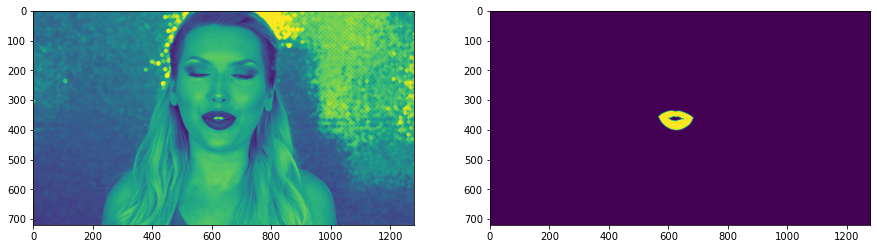

In [36]:
img = plt.imread(DATA_ROOT + '720p/image00000010.jpg')
mask = plt.imread(DATA_ROOT + 'mask/mask00000010.png')

print(img.shape, mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img[..., 1])
ax[1].imshow(mask[..., 1])
plt.show()

In [37]:
np.unique(mask * 255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 107., 108., 109., 110., 111., 112., 113.,
       114., 115., 116., 117., 119., 120., 121., 123., 124., 125., 126.,
       127., 128., 131., 132., 133., 134., 136., 137., 139., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 154.,
       155., 156., 157., 158., 159., 162., 163., 16

In [38]:
labels = ['Lips', 'Other']

[  0 255]


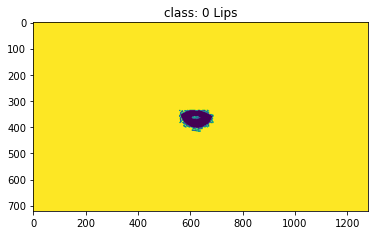

[  0 255]


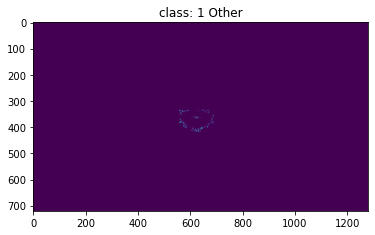

In [39]:
for i in range(2):
    mask = plt.imread(DATA_ROOT + '/mask/mask00000010.png') * 255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,1]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

In [40]:
df = pd.read_csv(DATA_ROOT + '/list.csv')
df['filename'] = DATA_ROOT + '/720p/' + df['filename']
df['mask'] = DATA_ROOT + '/mask/' + df['mask'] 
df = df[['filename', 'mask']]

df.sort_values(by='filename',inplace=True)
df = df.head(500)
df.reset_index(drop=True, inplace=True)

df.head()

,filename,mask
0,data/Pixel_Perfect_Lips_Segmentation/set-lipst...,data/Pixel_Perfect_Lips_Segmentation/set-lipst...
1,data/Pixel_Perfect_Lips_Segmentation/set-lipst...,data/Pixel_Perfect_Lips_Segmentation/set-lipst...
2,data/Pixel_Perfect_Lips_Segmentation/set-lipst...,data/Pixel_Perfect_Lips_Segmentation/set-lipst...
3,data/Pixel_Perfect_Lips_Segmentation/set-lipst...,data/Pixel_Perfect_Lips_Segmentation/set-lipst...
4,data/Pixel_Perfect_Lips_Segmentation/set-lipst...,data/Pixel_Perfect_Lips_Segmentation/set-lipst...


In [41]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [42]:
class SelfDrivingDataset(Dataset):
    
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
        
        for i in range(2):
            cls_mask = np.where(mask == i, 255, 0)
            cls_mask = cls_mask.astype('float')
            cls_mask = cv2.resize(cls_mask, (256, 256))

            masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)   

        return (img.float(), masks)

    def __len__(self):
        return self.data_len

In [58]:
# !pip install segmentation-models-pytorch

In [44]:
import segmentation_models_pytorch as smp

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# создание модели
BACKBONE = 'resnet34'
segmodel = smp.FPN(BACKBONE, classes=2, activation='softmax').to(device) #.Unet 
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/irina/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


<ipython-input-42-fb9f46528a22>:45: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([2, 256, 256])


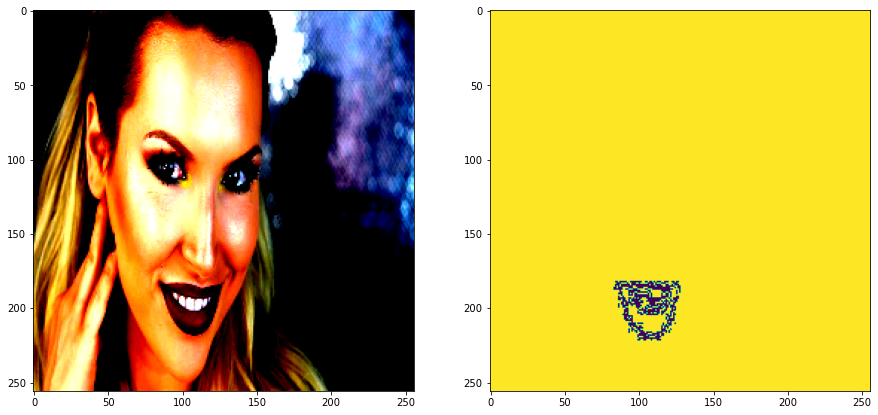

In [45]:
dataset = SelfDrivingDataset(df, preprocessing=preprocess_input)
img, masks = dataset[10]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 0])
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = SelfDrivingDataset(X_train,
                                preprocessing=preprocess_input)
test_data = SelfDrivingDataset(X_test,
                               preprocessing=preprocess_input)

In [47]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

In [48]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

<ipython-input-42-fb9f46528a22>:45: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([8, 3, 256, 256]) torch.Size([8, 2, 256, 256])
tensor(-1.9307) tensor(2.6400)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


In [49]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [50]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [51]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [52]:
# train model

max_score = 0

for i in range(0, 5):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
train:   0%|          | 0/44 [00:00<?, ?it/s]

<ipython-input-42-fb9f46528a22>:45: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


valid: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s, dice_loss - 0.003214, iou_score - 0.9936]
Model saved!
Epoch: 2
valid: 100%|██████████| 38/38 [00:17<00:00,  2.12it/s, dice_loss - 0.003212, iou_score - 0.9936]
Epoch: 3
valid: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s, dice_loss - 0.003212, iou_score - 0.9936]
Epoch: 4
valid: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s, dice_loss - 0.003212, iou_score - 0.9936]
Epoch: 5
valid: 100%|██████████| 38/38 [00:17<00:00,  2.11it/s, dice_loss - 0.003212, iou_score - 0.9936]


In [53]:
def get_orig(image):
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

<ipython-input-42-fb9f46528a22>:45: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


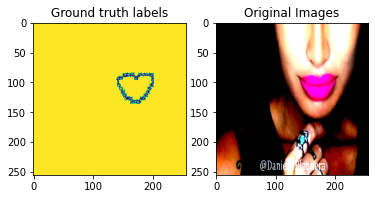

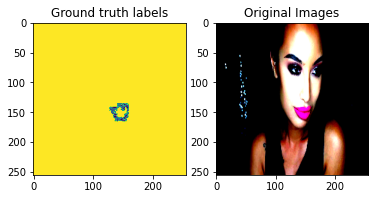

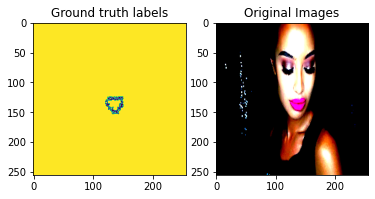

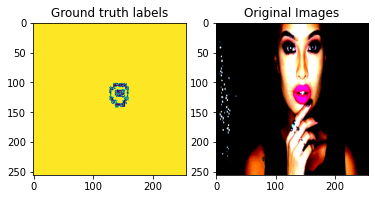

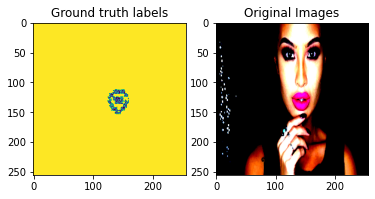

In [57]:
class_idx = 0

for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    f, axarr = plt.subplots(1,2)

    for j in range(0, 2):
        axarr[0].imshow(labels.detach().cpu().numpy()[j,class_idx, :,:])
        axarr[0].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[1].imshow(original)
        axarr[1].set_title('Original Images')
        plt.show()
    if i > 3:
        break